In [1]:
import os
import json
from datasets import load_from_disk, load_dataset, load_metric
import pickle
from rouge_score import rouge_scorer
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer
from dataset import CitationTextGenerationRAGDataset

In [3]:
stops = set(stopwords.words('english'))
rouge = load_metric("rouge")

In [4]:
def clean_stop(text):
    cleaned = []
    for word in text.split():
        if word not in stops:
            cleaned.append(word)
    return " ".join(cleaned)

In [5]:
def remove_citation_marks(text, citations):
    for citation in citations.split("#"):
        text = text.replace("\n"," ").replace(citation,"")
    return text

In [6]:
passages_path = os.path.join("cited_text_embeddings_sentence_better", "cited_papers")
#passages_path = "cited_text_embeddings_citation_mark/cited_papers"
cited_dataset = load_from_disk(passages_path)

In [13]:
outputs = []
with open("FiD_CTS_RAG_span_generation_sentence_pre_retrieval.jsonl") as f:
    for line in f:
        outputs.append(json.loads(line))

In [8]:
def ROUGE(predictions, references, use_stemmer=True):
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=use_stemmer)
    return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}

In [9]:
def ROUGE_recall(predictions, references, use_stemmer=True):
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=use_stemmer)
    return {k: round(v.mid.recall * 100, 4) for k, v in result.items()}

In [14]:
outputs[0]

{'id': '202769115_0_0_2@5535381',
 'source': '[B_Dominant] (Yin et al., 2015) [E_Dominant] Sequence Matching task has attracted lots of attention in the past decades.\nThere are many related works on Question Answering(QA) (Yin et al., 2015; Tay et al., 2018; Wang et al., 2017; Tymoshenko and Moschitti, 2018; Min et al., 2017) , Natural Language Inference(NLI) (Peters et al., 2018; Kim et al., 2018; and so on.\n [Dominant] [MASK]',
 'target': '(Yin et al., 2015) use attention mechanism with convolutional layer to model sentence pairs.',
 'citations': '(Yin et al., 2015)',
 'citation_links': 'D5535381',
 'retrieved_doc_ids': [4381638,
  4381644,
  4381641,
  4381668,
  4381658,
  4381640,
  4381706,
  4381661,
  4381664,
  4381660],
 'prediction': '(Yin et al., 2015) proposed three attention schemes that integrate mutual influence between sentences into CNNs.',
 'gold_label': '(Yin et al., 2015) use attention mechanism with convolutional layer to model sentence pairs.'}

In [15]:
for idx in outputs[0]["retrieved_doc_ids"]:
    if idx >= 0:
        cited_text = cited_dataset[idx]["text"]
        print(cited_text)

Title: ABCNN: Attention-Based Convolutional Neural Network for Modeling Sentence Pairs
Abstract: (ii) We propose three attention schemes that integrate mutual influence between sentences into CNNs; thus, the representation of each sentence takes into consideration its counterpart.
Abstract: This work presents a general Attention Based Convolutional Neural Network (ABCNN) for modeling a pair of sentences.
Introduction: CNNs benefit from incorporating attention into representations of local phrases detected by filters; in contrast, LSTMs encode the whole context to form attention-based word representations -a strategy that is more complex than the CNN strategy and (as our experiments suggest) performs less well for some tasks.
Introduction: This work presents the ABCNN, an attention-based convolutional neural network, that has a powerful mechanism for modeling a sentence pair by taking into account the interdependence between the two sentences.
Abstract: Most prior work (i) deals with on

In [11]:
use_stemmer = True
cleaned_predictions = []
prediction_no_stop = []
cleaned_targets = []
target_no_stop = []
all_retrieved = []
retrieved_by_rank = [[] for i in range(10)]
for candidate in tqdm(outputs):
    prediction = remove_citation_marks(candidate["prediction"], candidate["citations"])
    #prediction = candidate["prediction"]
    cleaned_predictions.append(prediction)
    target = remove_citation_marks(candidate["target"], candidate["citations"])
    #target = candidate["target"]
    cleaned_targets.append(target)

    all_retrieved_texts = []
    for idx in candidate["retrieved_doc_ids"]:
        if idx >= 0:
            cited_text = cited_dataset[idx]["text"]
            all_retrieved_texts.append(cited_text)
    cleaned_target = clean_stop(candidate["target"])
    target_no_stop.append(cleaned_target)
    cleaned_prediction = clean_stop(candidate["prediction"])
    prediction_no_stop.append(cleaned_prediction)
    all_retrieved.append(" ".join(all_retrieved_texts))

    for i, idx in enumerate(candidate["retrieved_doc_ids"]):
        if idx >= 0:
            retrieved_by_rank[i].append(cited_dataset[idx]["text"])
        else:
            retrieved_by_rank[i].append("")

print(ROUGE(cleaned_predictions, cleaned_targets, use_stemmer=use_stemmer))
print(ROUGE(all_retrieved, target_no_stop, use_stemmer=use_stemmer))
print(ROUGE_recall(all_retrieved, target_no_stop, use_stemmer=use_stemmer))
print(ROUGE_recall(all_retrieved, prediction_no_stop, use_stemmer=use_stemmer))
#for i in range(10):
#    print(ROUGE_recall(retrieved_by_rank[i], prediction_no_stop, use_stemmer=use_stemmer))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:03<00:00, 342.71it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 33.4817, 'rouge2': 14.3956, 'rougeL': 27.7048, 'rougeLsum': 27.6663}


INFO:absl:Using default tokenizer.


{'rouge1': 15.9931, 'rouge2': 5.9101, 'rougeL': 11.8588, 'rougeLsum': 11.8443}


INFO:absl:Using default tokenizer.


{'rouge1': 54.0094, 'rouge2': 20.9114, 'rougeL': 40.6805, 'rougeLsum': 40.6618}
{'rouge1': 72.7224, 'rouge2': 37.8084, 'rougeL': 61.9714, 'rougeLsum': 62.0181}


In [78]:
N_docs = [3,5,8,10,12,15,20]
prediction_files = [
    "FiD_CTS_RAG_span_generation_sentence_oracle_final_n_docs=3.jsonl",
    "FiD_CTS_RAG_span_generation_sentence_oracle_final_n_docs=5.jsonl",
    "FiD_CTS_RAG_span_generation_sentence_oracle_final_n_docs=8.jsonl",
    "FiD_CTS_RAG_span_generation_sentence_oracle.jsonl",
    "FiD_CTS_RAG_span_generation_sentence_oracle_final_n_docs=12.jsonl",
    "FiD_CTS_RAG_span_generation_sentence_oracle_final_n_docs=15.jsonl",
    "FiD_CTS_RAG_span_generation_sentence_oracle_final_n_docs=20.jsonl",
]

In [79]:
all_cleaned_ROUGE = []
all_original_ROUGE = []
for N_doc, file_name in zip(N_docs, prediction_files):
    outputs = []
    with open(file_name) as f:
        for line in f:
            outputs.append(json.loads(line))

    use_stemmer = True
    cleaned_predictions = []
    predictions = []
    cleaned_targets = []
    targets = []
    for candidate in tqdm(outputs):
        prediction = remove_citation_marks(candidate["prediction"], candidate["citations"])
        #prediction = candidate["prediction"]
        cleaned_predictions.append(prediction)
        target = remove_citation_marks(candidate["target"], candidate["citations"])
        #target = candidate["target"]
        cleaned_targets.append(target)
        targets.append(candidate["target"])
        predictions.append(candidate["prediction"])

    cleaned_ROUGE = ROUGE(cleaned_predictions, cleaned_targets, use_stemmer=use_stemmer)
    original_ROUGE = ROUGE(predictions, targets, use_stemmer=use_stemmer)
    all_cleaned_ROUGE.append(cleaned_ROUGE)
    all_original_ROUGE.append(original_ROUGE)
    print(cleaned_ROUGE)
    print(original_ROUGE)

100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 134662.58it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 33.5009, 'rouge2': 14.4039, 'rougeL': 27.6676, 'rougeLsum': 27.6762}
{'rouge1': 46.8733, 'rouge2': 28.4581, 'rougeL': 41.3286, 'rougeLsum': 41.7176}


100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 344174.36it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 34.7311, 'rouge2': 15.1275, 'rougeL': 28.6046, 'rougeLsum': 28.5911}
{'rouge1': 47.8181, 'rouge2': 28.9248, 'rougeL': 41.9977, 'rougeLsum': 42.3886}


100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 343310.07it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 35.1946, 'rouge2': 15.1802, 'rougeL': 28.912, 'rougeLsum': 28.8962}
{'rouge1': 48.231, 'rouge2': 29.0987, 'rougeL': 42.2802, 'rougeLsum': 42.8251}


100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 331302.77it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 35.727, 'rouge2': 15.5487, 'rougeL': 29.226, 'rougeLsum': 29.2127}
{'rouge1': 48.6584, 'rouge2': 29.3228, 'rougeL': 42.4457, 'rougeLsum': 42.9323}


100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 340651.26it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 35.747, 'rouge2': 15.016, 'rougeL': 28.8878, 'rougeLsum': 28.8883}
{'rouge1': 48.544, 'rouge2': 28.8444, 'rougeL': 42.1079, 'rougeLsum': 42.6641}


100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 338871.21it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 35.8329, 'rouge2': 15.0232, 'rougeL': 29.0939, 'rougeLsum': 29.0856}
{'rouge1': 48.4125, 'rouge2': 28.6756, 'rougeL': 42.0983, 'rougeLsum': 42.5857}


100%|███████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 340788.97it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


{'rouge1': 36.2854, 'rouge2': 15.1495, 'rougeL': 29.3451, 'rougeLsum': 29.3303}
{'rouge1': 48.4842, 'rouge2': 28.4827, 'rougeL': 41.9389, 'rougeLsum': 42.6299}


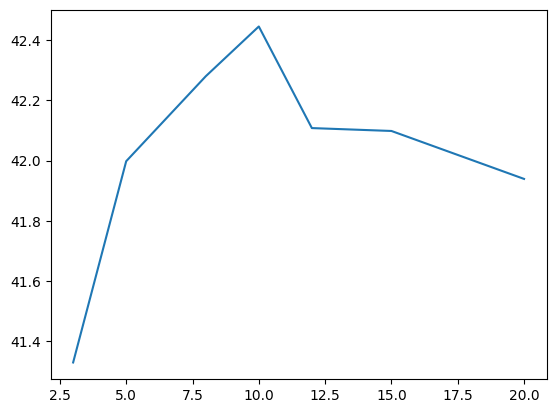

In [83]:
ROUGE_L = [r["rougeL"] for r in all_original_ROUGE]
plt.figure()
plt.plot(N_docs, ROUGE_L)
plt.show()

In [ ]:
keywords_lookup = {}
with open("keyword_sentence_CTS_test.jsonl") as f:
    for line in f:
        obj = json.loads(line)
        keywords_lookup[obj["id"]] = obj["keywords"]

In [ ]:
all_keywords = []
for candidate in tqdm(outputs):
    keywords = keywords_lookup[candidate["id"]]
    all_keywords.append(" @@ ".join(keywords))
print(ROUGE_recall(all_keywords, target_no_stop, use_stemmer=use_stemmer))


In [58]:
all_retrieved_sections   = []
for candidate in tqdm(outputs):
    for idx in candidate["retrieved_doc_ids"]:
        if idx >= 0:
            cited_text = cited_dataset[idx]["text"].split(": ")[0]
            all_retrieved_sections.append(cited_text)

100%|██████████████████████████████████████████████████████████████| 1206/1206 [00:06<00:00, 196.98it/s]


In [59]:
cleaned_section_names = []
for section in all_retrieved_sections:
    cleaned_section = section.lower()
    if "introduction" in cleaned_section:
        cleaned_section = "introduction"
    if "conclusion" in cleaned_section:
        cleaned_section = "conclusion"
    if "experiment" in cleaned_section:
        cleaned_section = "experimental results"
    if "result" in cleaned_section:
        cleaned_section = "experimental results"
    if "model" in cleaned_section:
        cleaned_section = "model or architecture"
    if "architecture" in cleaned_section:
        cleaned_section = "model or architecture"
    if "approach" in cleaned_section:
        cleaned_section = "approach"
    if "method" in cleaned_section:
        cleaned_section = "approach"
    if "data" in cleaned_section:
        cleaned_section = "data"
    if "evaluation" in cleaned_section:
        cleaned_section = "evaluation"
    cleaned_section_names.append(cleaned_section)

In [60]:
section_counts = Counter(cleaned_section_names)

In [61]:
len(all_retrieved_sections)

11973

In [62]:
section_counts.most_common()

[('introduction', 4140),
 ('abstract', 3667),
 ('title', 921),
 ('related work', 401),
 ('model or architecture', 383),
 ('conclusion', 316),
 ('approach', 141),
 ('experimental results', 92),
 ('data', 75),
 ('background', 54),
 ('', 40),
 ('evaluation', 38),
 ('overview', 26),
 ('state of the art', 22),
 ('proceedings of the 36', 16),
 ('discussion', 15),
 ('sentence:', 14),
 ('dependency path embeddings', 13),
 ('baselines', 12),
 ('tasks', 11),
 ('problem formulation', 11),
 ('is the abusive content explicit or implicit?', 11),
 ('back-boost learning', 9),
 ('task definition', 9),
 ('simple surface features', 9),
 ('related works', 9),
 ('abstract graph', 9),
 ('neural machine translation', 8),
 ('2', 8),
 ('analysis', 8),
 ('unsupervised and weakly supervised bilingual embeddings', 7),
 ('arxiv:1805.06266v2 [cs.cl] 5 jul 2018', 7),
 ('problem statement', 7),
 ('transfer learning', 7),
 ('-mark twain', 7),
 ('adversarial training', 7),
 ('nb', 7),
 ('augmenting relation extraction'

In [ ]:
outputs[4]

In [ ]:
for idx in outputs[4]["retrieved_doc_ids"]:
    if idx >= 0:
        cited_text = cited_dataset[idx]["text"]
        print(cited_text)

In [ ]:
generation_rouge = {}
retrieval_rouge_recall = {}
retrieval_rouge = {}
prediction_rouge = [{} for i in range(6)]
for candidate in tqdm(outputs):
    prediction = remove_citation_marks(candidate["prediction"], candidate["citations"])
    #prediction = candidate["prediction"]
    target = remove_citation_marks(candidate["target"], candidate["citations"])
    #target = candidate["target"]
    scores = scorer.score(target,prediction)
    generation_rouge[candidate["id"]] = scores["rouge1"].fmeasure
    all_retrieved_texts = []
    for idx in candidate["retrieved_doc_ids"]:
        if idx >= 0:
            cited_text = cited_dataset[idx]["text"]
            all_retrieved_texts.append(cited_text)
    cleaned_target = clean_stop(candidate["target"])
    cleaned_prediction = clean_stop(candidate["prediction"])
    scores = scorer.score(cleaned_target," ".join(all_retrieved_texts))
    retrival_f1 = (scores["rouge1"].fmeasure + scores["rouge2"].fmeasure) / 2
    retrival_recall = (scores["rouge1"].recall + scores["rouge2"].recall) / 2
    retrieval_rouge_recall[candidate["id"]] = retrival_recall
    retrieval_rouge[candidate["id"]] = retrival_f1
    scores = scorer.score(cleaned_prediction," ".join(all_retrieved_texts))
    prediction_rouge[0][candidate["id"]] = (scores["rouge1"].recall + scores["rouge2"].recall) / 2
    for i, text in enumerate(all_retrieved_texts):
        scores = scorer.score(cleaned_prediction,text)
        prediction_rouge[i+1][candidate["id"]] = (scores["rouge1"].recall + scores["rouge2"].recall) / 2

In [ ]:
np.mean(list(generation_rouge.values()))

In [ ]:
np.mean(list(retrieval_rouge.values()))

In [ ]:
np.mean(list(retrieval_rouge_recall.values()))

In [ ]:
np.mean(list(prediction_rouge[0].values()))

In [ ]:
np.mean(list(prediction_rouge[1].values()))

In [ ]:
np.mean(list(prediction_rouge[2].values()))

In [ ]:
np.mean(list(prediction_rouge[3].values()))

In [ ]:
np.mean(list(prediction_rouge[4].values()))

In [ ]:
np.mean(list(prediction_rouge[5].values()))

In [ ]:
outputs = []
with open("LED_best_standard_prediction.jsonl") as f:
    for line in f:
        outputs.append(json.loads(line))

In [ ]:
generation_rouge = {}
for candidate in tqdm(outputs):
    prediction = remove_citation_marks(candidate["prediction"][0], candidate["citations"])
    #prediction = candidate["prediction"]
    target = remove_citation_marks(candidate["target"], candidate["citations"])
    #target = candidate["target"]
    scores = scorer.score(target,prediction)
    generation_rouge[candidate["id"]] = scores["rouge1"].fmeasure

In [ ]:
prediction

In [ ]:
target

In [ ]:
np.mean(list(generation_rouge.values()))

In [ ]:
ranked_rouge = {}
for candidate in tqdm(outputs):
    retrieval_scores = []
    for cited_id in candidate["citation_links"].split("@"):
        this_paper_bool = np.array(cited_dataset["paper_id"]) == cited_id
        this_paper_indices = np.arange(this_paper_bool.size)[this_paper_bool]
        this_paper_paragraphs = cited_dataset[this_paper_indices]
        for paragraph in this_paper_paragraphs["text"]:
            scores = scorer.score(candidate["target"],paragraph)
            retrival_score = (scores["rouge1"].recall + scores["rouge2"].recall) / 2
            retrieval_scores.append(retrival_score)
    ranked_rouge[candidate["id"]] = np.mean(np.sort(retrieval_scores)[::-1][:5])

In [ ]:
np.mean(list(ranked_rouge.values()))

In [ ]:
special_tokens = ['<doc>', '</doc>', '[BOS]']
additional_special_tokens = {'additional_special_tokens': special_tokens}
question_encoder_tokenizer = AutoTokenizer.from_pretrained("allenai/aspire-sentence-embedder")
question_encoder_tokenizer.add_special_tokens(additional_special_tokens)

In [ ]:
dataset = CitationTextGenerationRAGDataset(
     "/home/data/XiangciLi/CORWA/annotated_train", question_encoder_tokenizer,
     MAX_SENT_LEN=512,
     include_conclusion=False,
     include_intro = False,
     skip_no_citations = True,
     auto_regressive=True, 
     dominant_only=True,
     related_work_path='/home/data/XiangciLi/20200705v1/acl/selected_related_work.jsonl',
     cited_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_cited_pdf_parses.jsonl",
     citing_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_pdf_parses.jsonl",
     limit = None,
     cited_paper_ids = set(cited_dataset["paper_id"]),
)

In [ ]:
ranked_cited_paragraph = {}
for candidate in tqdm(dataset):
    retrieval_scores = []
    cited_indices = []
    for type_cited_id in candidate["citation_links"].split("@"):
        cited_id = type_cited_id[1:]
        this_paper_bool = np.array(cited_dataset["paper_id"]) == cited_id
        this_paper_indices = np.arange(this_paper_bool.size)[this_paper_bool]
        cited_indices.extend(this_paper_indices.tolist())
        this_paper_paragraphs = cited_dataset[this_paper_indices]
        for paragraph in this_paper_paragraphs["text"]:
            scores = scorer.score(candidate["target"],paragraph)
            retrival_score = (scores["rouge1"].recall + scores["rouge2"].recall) / 2
            retrieval_scores.append(retrival_score)
    cited_indices = np.array(cited_indices)
    sorted_local_indices = np.argsort(retrieval_scores)[::-1]
    sorted_rouge_scores = np.array(retrieval_scores)[sorted_local_indices]
    sorted_cited_paragraph_indices = cited_indices[sorted_local_indices]
    ranked_cited_paragraph[candidate["id"]] = {
        "scores": sorted_rouge_scores.tolist(),
        "cited_indices": sorted_cited_paragraph_indices.tolist(),
    }